### Network Simulation 

In [14]:
import networkx as nx
import analysis_functions
import random
import math
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Define the parameters
n = 100  # Number of nodes
p = 0.05  # Probability of edge creation
num_networks = 3
num_network_permutations = 50  # Number of network permutations 
edge_share_values = [0, 0.1, 0.25, 0.5, 0.7, 0.8, 0.9, 1] # Define the share of edges to remove

# Create the original ER network with the specified seed
er_networks = [nx.erdos_renyi_graph(n, p, seed=i) for i in range(num_networks)]

In [4]:
all_modified_networks = {}

# Iterate over each original network
for idx, er_network in enumerate(er_networks):
    # Initialize the dictionary to store modified networks for the current original network
    modified_networks = {}
    
    # Iterate over each edge share value
    for edge_share in edge_share_values:
        # Initialize a list to store modified networks for the current edge share
        modified_networks[edge_share] = []
        
        # Iterate for each network
        for i in range(1, num_network_permutations + 1):
            # Create a copy of the original network
            network_copy = er_network.copy()

            # Randomly choose edges to remove based on the current edge share
            edges_to_remove = random.sample(list(network_copy.edges()), int(edge_share * network_copy.number_of_edges()))

            # Remove the chosen edges from the graph
            network_copy.remove_edges_from(edges_to_remove)
            
            # Append the modified network to the list for the current edge share
            modified_networks[edge_share].append(network_copy)
    
    # Store the modified networks dictionary in the main dictionary
    all_modified_networks[f'network_{idx+1}'] = modified_networks

In [5]:
# Define a function to get the first-order connections of a node
def get_first_order_connections(graph, node):
    neighbors = set(graph.neighbors(node))
    neighbors.add(node)  # Add the node itself to its group
    return neighbors

In [6]:
all_groups = {}

# Iterate over each original network's modified networks
for network_key, modified_networks in all_modified_networks.items():
    all_groups[network_key] = {}
    
    # Loop through the modified networks and create groups
    for edge_share, networks in modified_networks.items():
        all_groups[network_key][edge_share] = {}  # Initialize a dictionary for this edge share value
        
        for idx, net in enumerate(networks):
            # Create groups based on first-order connections
            groups = {}
            for node in net.nodes:
                groups[node] = list(get_first_order_connections(net, node))

            # Store the groups in the dictionary for this network
            group_dict = {f"Group {node} {network_key}": group for node, group in groups.items()}
            all_groups[network_key][edge_share][f"G{idx+1}"] = group_dict

In [7]:
# Generate lists of networks to combine
list_networks_to_combine = []
for i in range(2, num_networks + 1):
    list_networks_to_combine.append([f'network_{j}' for j in range(1, i + 1)])

# Print the generated list
print(list_networks_to_combine)

[['network_1', 'network_2'], ['network_1', 'network_2', 'network_3']]


In [8]:
# Initialize a new dictionary to store the combined groupings
all_combined_groups = {}

# Iterate over each list of networks to combine
for networks_to_combine in list_networks_to_combine:
    # Initialize a dictionary to store the combined groupings for this combination
    combined_groups = {}
    
    # Iterate over each edge share value
    for edge_share, edge_share_data in all_groups[networks_to_combine[0]].items():  # Assuming all networks have the same edge share values
        combined_groups[edge_share] = {}
        
        # Combine groupings from all specified networks for the current edge share value and each Gi
        for Gi in edge_share_data.keys():
            combined_groups[edge_share][Gi] = {}
            for network_key in networks_to_combine:
                if edge_share in all_groups[network_key]:
                    network_data = all_groups[network_key][edge_share]
                    if Gi in network_data:
                        groups = network_data[Gi]
                        for group_name, nodes in groups.items():
                            if group_name not in combined_groups[edge_share][Gi]:
                                combined_groups[edge_share][Gi][group_name] = nodes
                            else:
                                combined_groups[edge_share][Gi][group_name].extend(nodes)
                                combined_groups[edge_share][Gi][group_name] = list(set(combined_groups[edge_share][Gi][group_name]))
    
    # Store the combined groupings for this combination in the overall dictionary
    all_combined_groups[str(networks_to_combine)] = combined_groups


In [9]:
node_values = {node: 10 for node in er_network.nodes}

In [10]:
# Assuming you have the function `analysis_functions.connection_oriented_cluster_match`
# and the `node_values` dictionary defined

# Initialize an empty dictionary to store the results
results = {}

# Loop through all networks in all_groups
for network_key, edge_share_groups in all_combined_groups.items():
    print(network_key)
    # Initialize a dictionary for each network
    results[network_key] = {}

    # Loop through all edge share values for the current network
    for edge_share, network_groups in edge_share_groups.items():
        # Initialize a dictionary for each edge share value
        results[network_key][edge_share] = {}
        
        # Loop through all networks for the current edge share value
        for network_name, groups in network_groups.items():
            # Calculate the score for the current network
            score = analysis_functions.connection_oriented_cluster_match(groups, node_values)
            
            # Store the score in the results dictionary
            results[network_key][edge_share][network_name] = score


['network_1', 'network_2']
['network_1', 'network_2', 'network_3']


In [11]:
# Initialize an empty dictionary to store the results
base_network_results = {}

# Access 'network_1' directly
network_key = 'network_1'

# Loop through all edge share values for 'network_1'
for edge_share, network_groups in all_groups[network_key].items():
    # Initialize a dictionary for each edge share value
    base_network_results[edge_share] = {}
    
    # Loop through all groups for the current edge share value
    for group_name, groups in network_groups.items():
        # Calculate the score for the current group
        score = analysis_functions.connection_oriented_cluster_match(groups, node_values)
        
        # Store the score in the results dictionary
        base_network_results[edge_share][group_name] = score


In [12]:
# Calculate plurality and quadratic score of the original network 

# generate groups 
original_groups = {}
for node in er_networks[0].nodes:
    original_groups[node] = list(get_first_order_connections(er_networks[0], node))

plurality_score = analysis_functions.connection_oriented_cluster_match(original_groups, node_values)
quadratic_score = sum(math.sqrt(value) for value in node_values.values())

plurality_score, quadratic_score

(207.58380564804568, 316.2277660168381)

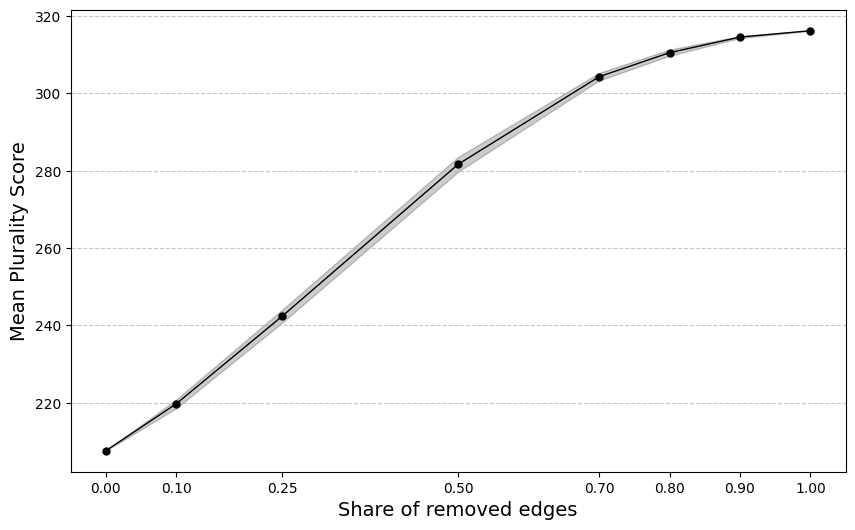

In [15]:
# Calculate mean plurality scores and standard deviations for each share
mean_scores = []
std_devs = []

for edge_share, scores in base_network_results.items():
    mean_score = np.mean(list(scores.values()))
    std_dev = np.std(list(scores.values()))
    mean_scores.append(mean_score)
    std_devs.append(std_dev)

plt.figure(figsize=(10, 6))

plt.plot(edge_share_values, mean_scores, '-o', color='black', label='Mean Plurality Score',
         markersize=5, linewidth=1)

plt.fill_between(edge_share_values, 
                 np.array(mean_scores) - np.array(std_devs), 
                 np.array(mean_scores) + np.array(std_devs), 
                 color='black', alpha=0.2)

plt.xlabel('Share of removed edges', fontsize=14)
plt.ylabel('Mean Plurality Score', fontsize=14)
plt.xticks(edge_share_values)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig('plots-and-tables/scores.png')

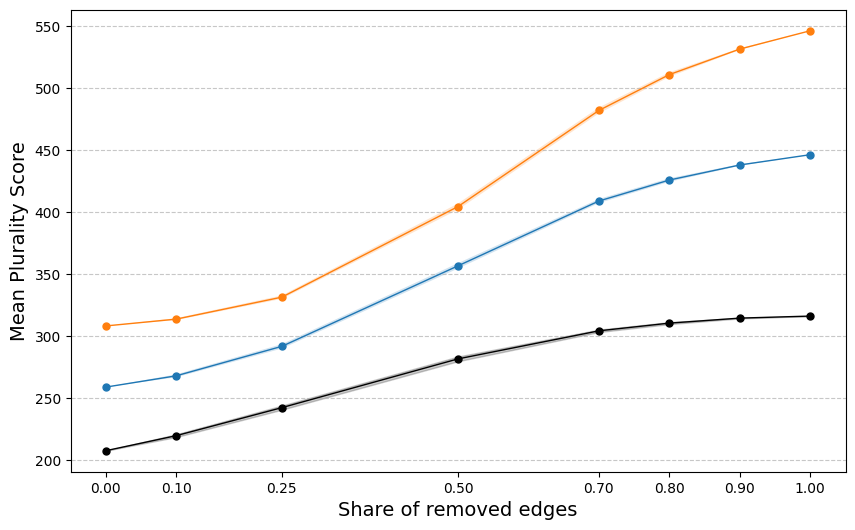

In [16]:
# Calculate mean plurality scores and standard deviations for each share in base_network_results
mean_scores = []
std_devs = []

for edge_share, scores in base_network_results.items():
    mean_score = np.mean(list(scores.values()))
    std_dev = np.std(list(scores.values()))
    mean_scores.append(mean_score)
    std_devs.append(std_dev)

# Plot the mean plurality scores with error bands indicating the standard deviations
plt.figure(figsize=(10, 6))

# Plot mean scores
plt.plot(edge_share_values, mean_scores, '-o', color='black', label='Mean Plurality Score',
         markersize=5, linewidth=1)

# Plot error bands
plt.fill_between(edge_share_values, 
                 np.array(mean_scores) - np.array(std_devs), 
                 np.array(mean_scores) + np.array(std_devs), 
                 color='black', alpha=0.2)

plt.xticks(edge_share_values)
plt.xlabel('Share of removed edges', fontsize=14)  # Increase font size of x-axis label
plt.ylabel('Mean Plurality Score', fontsize=14)  # Increase font size of y-axis label
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot additional lines with error bands for each key in results
for key, data in results.items():
    key_mean_scores = []
    key_std_devs = []
    for edge_share, scores in data.items():
        mean_score = np.mean(list(scores.values()))
        std_dev = np.std(list(scores.values()))
        key_mean_scores.append(mean_score)
        key_std_devs.append(std_dev)
    
    # Plot mean scores for each key
    plt.plot(edge_share_values, key_mean_scores, '-o', label=key, markersize=5, linewidth=1)
    
    # Plot error bands for each key
    plt.fill_between(edge_share_values, 
                     np.array(key_mean_scores) - np.array(key_std_devs), 
                     np.array(key_mean_scores) + np.array(key_std_devs), 
                     alpha=0.2)

# Save the plot
plt.savefig('plots-and-tables/scores.png')

(-0.869776442416286,
 1.177671064663991,
 -0.7090321399293094,
 0.7009673713230685)

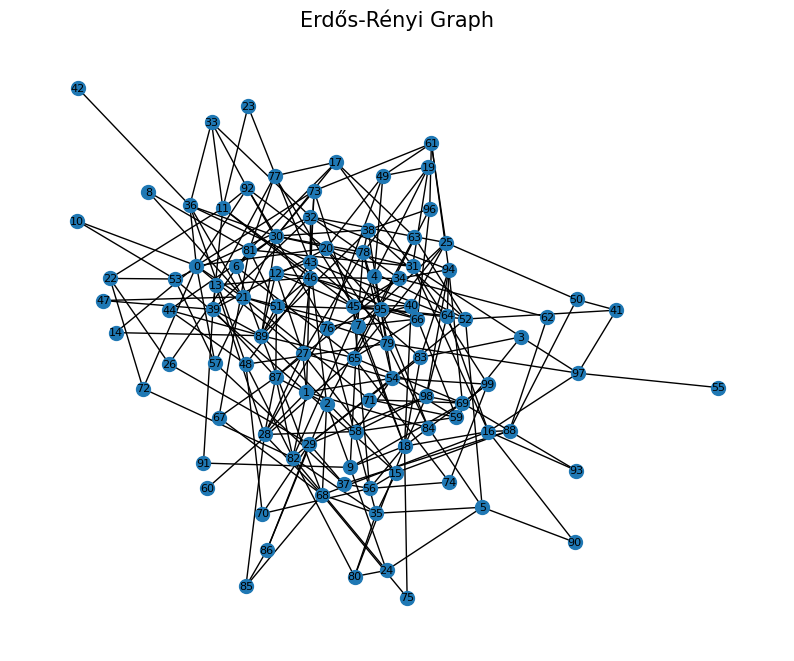

In [17]:
# Generate an Erdős-Rényi graph
test_network = nx.erdos_renyi_graph(100, 0.05, seed=1)

# Generate positions for the nodes using Fruchterman-Reingold layout
pos = nx.spring_layout(test_network, seed=1)

# Draw the network with improved visual parameters
plt.figure(figsize=(10, 8))  # Adjust the figure size

# Node customization
nx.draw_networkx(test_network, pos=pos, with_labels=True, node_size=100, font_size=8)

plt.title("Erdős-Rényi Graph", fontsize=15) 
plt.axis('off')

In [18]:
exp_num_edges = (p*(n*(n-1)))/2
exp_num_edges

247.5